<a href="https://colab.research.google.com/github/sirsjosh/Computer-Vision/blob/main/efficient_self_attention_intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to the `Efficient Self-Attention Intuition` Workshop!
In this workshop, we'll try to visually understand following concepts:
- Overlap Patch Embedding / Merging
- Efficient Self Attention

### Library imports

In [1]:
# basic imports
import pickle
import numpy as np
import matplotlib.pyplot as plt

# utility library for transforming tensors
#!pip install -q einops
#!pip install -q ipympl
#!pip install -q segmentation-models-pytorch
from einops import rearrange

# enable custom widgets
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/attention_concept_data.pickle

--2024-12-19 14:15:39--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/attention_concept_data.pickle
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 3.5.204.157, 52.95.155.86
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|3.5.204.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92013117 (88M) [application/x-www-form-urlencoded]
Saving to: ‘attention_concept_data.pickle’

attention_concept_d 100%[===================>]  87.75M  28.9MB/s    in 3.0s    

2024-12-19 14:15:43 (28.9 MB/s) - ‘attention_concept_data.pickle’ saved [92013117/92013117]



### Read input data

In [3]:
with open('attention_concept_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())

dict_keys(['key', 'query', 'value', 'attn', 'rgb_img', 'tf_img', 'patch_embed_output'])


In [4]:
print(data['rgb_img'].shape)

(512, 1024, 3)


### Plot the Image

In [5]:
def plot_single_channel_image(inputData, figsize, figTitle, save_plot = False, cmap=None,
                            plot_colorbar = False):
    fig = plt.figure(figsize=figsize)
    im = plt.imshow(inputData, cmap = cmap)
    plt.suptitle(figTitle);
    plt.axis('off');

    if(plot_colorbar):
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)

    if(save_plot):
        plt.savefig(f"{figTitle}.png")

### Show the Input Image

In [6]:
!pip install matplotlib==3.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.1/37.1 MB 41.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
nopassword
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 193, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 240, in _build_one_

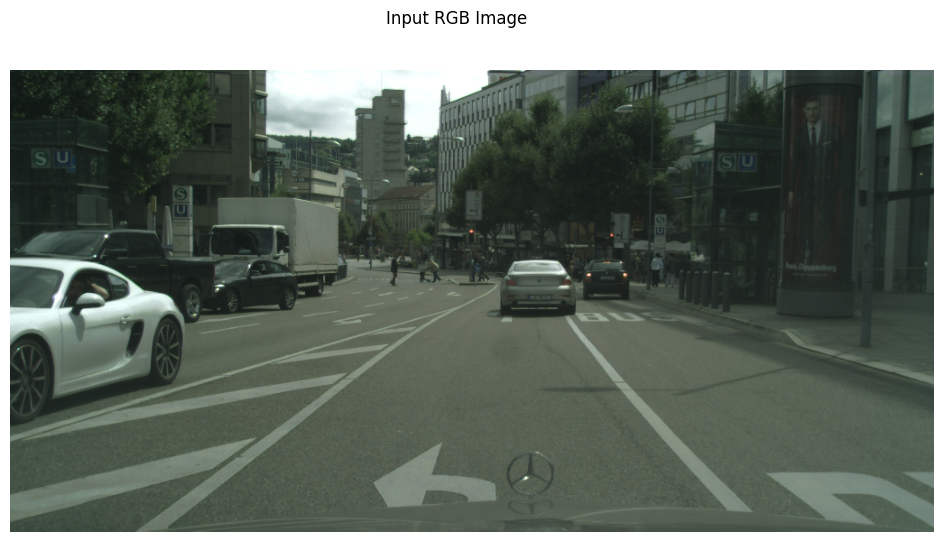

In [8]:
plot_single_channel_image(data['rgb_img'], (12,6), 'Input RGB Image')

## Overlap patch Embedding / Merging
- Entire image is split into patches which are passed to consequent Transformer blocks
- This layer acts like Embedding layer using Convolution layers
- Initial stage outputs indicate low-level features like edge detection and more abstract features in later stages

In [9]:
def plot_channels(inputData, num_rows, num_cols, figsize, figTitle, save_plot = False, cmap=None,
                  plot_colorbar = False):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(len(axes)):
        im = axes[i].imshow(inputData[i], cmap=cmap)
        axes[i].axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(figTitle);

    if(plot_colorbar):
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)

    if(save_plot):
        fig.savefig(f"{figTitle}.png")

patch_embed_output.shape = (32768, 64)
patch_embed_img.shape = (64, 128, 256)


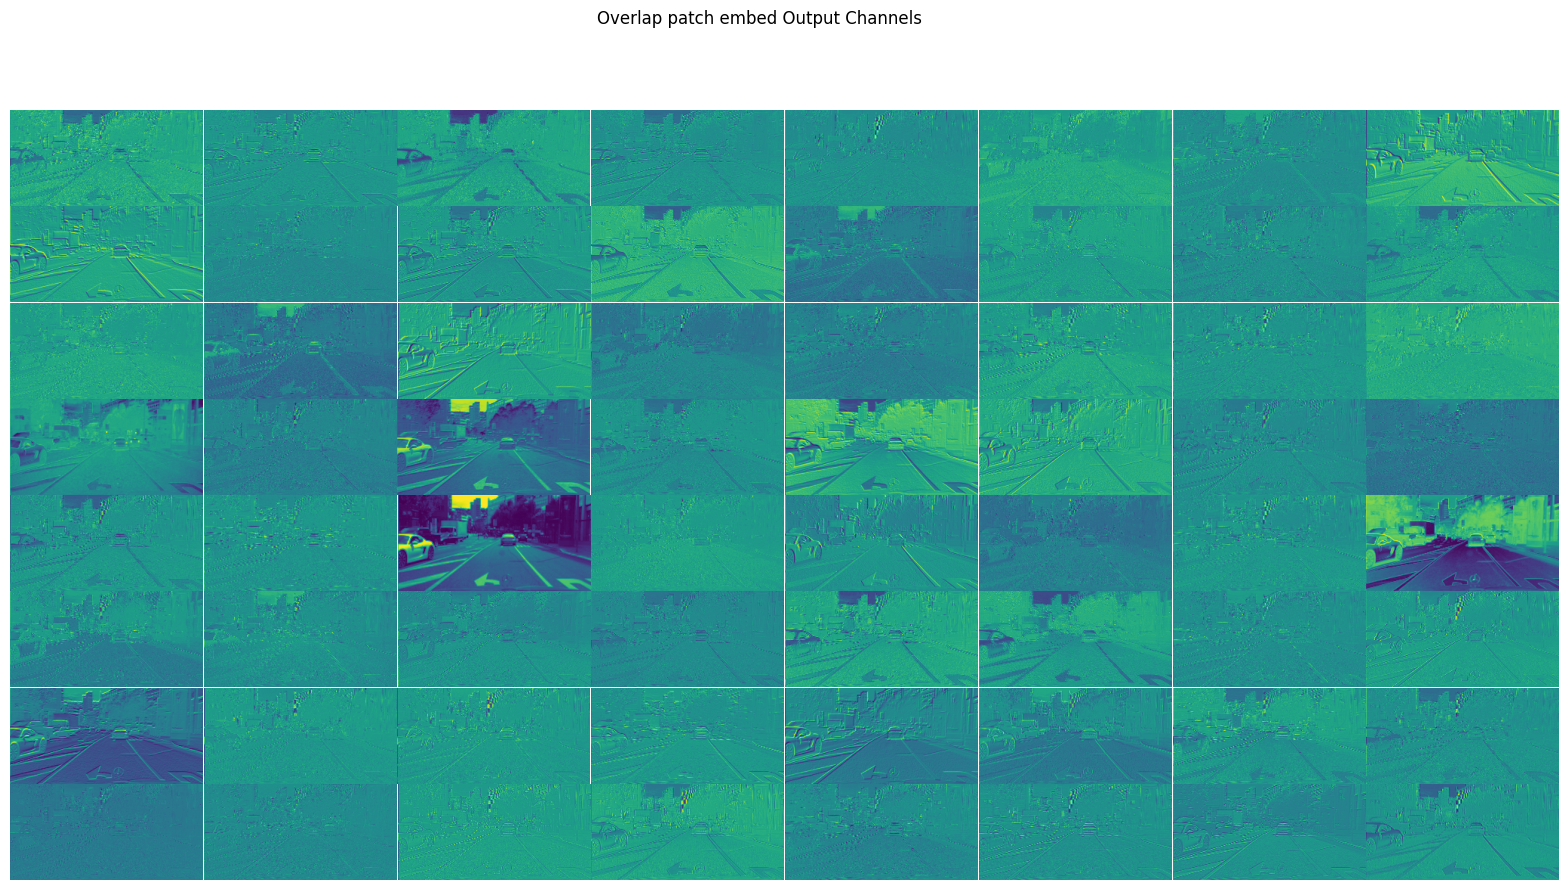

In [10]:
# read patch embedding layer output
patch_embed_output = data['patch_embed_output'][0]
print(f"patch_embed_output.shape = {patch_embed_output.shape}")

patch_embed_img = rearrange(patch_embed_output, '(h w) c -> c h w', h=128, w=256)
print(f"patch_embed_img.shape = {patch_embed_img.shape}")

# plot each channel of patch embedding
plot_channels(patch_embed_img, 8, 8, (20,10), 'Overlap patch embed Output Channels')

## Attention mechanism
- Attention mechanism involves 3 components - **Query, Key and Value**
- It is a mapping of a query and a set of key-value pairs to an output,
- Output is computed as a weighted sum of the values, where the weight assigned to each value is computed by similarity b/w query and corresponding key

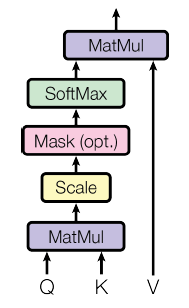

[Image reference](https://arxiv.org/abs/1706.03762)

**NOTE**
- Keys refer to input space (eg : embedded version of image coordinates)
- Query refers to output space (eg : Euclidean space in metres)
- Value can be any property in output space (eg: Depth, Speed of object at that location etc)

In [11]:
print(data.keys())

dict_keys(['key', 'query', 'value', 'attn', 'rgb_img', 'tf_img', 'patch_embed_output'])


## Query Visualization
- Query tries to match with certain features of specific type

query_img.shape = (64, 128, 256)


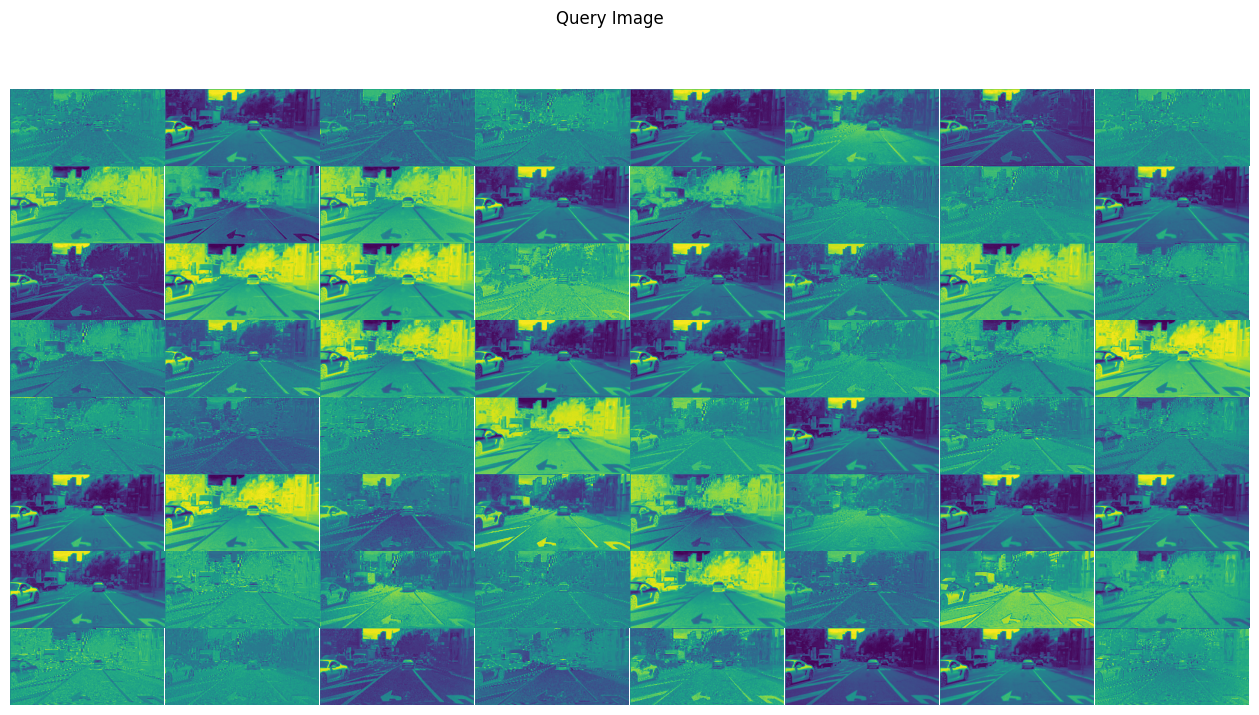

In [12]:
# query for first stage first block of transformer
query = data['query'][0][0]
query_img = rearrange(query, '(h w) c -> c h w', h=128, w=256)
print(f"query_img.shape = {query_img.shape}")

# plot each channel of Query
plot_channels(query_img, 8, 8, (16,8), 'Query Image')

## Key Visualization
- Key vector encodes that it's part of some object at some pixel location in input space and looking for features of specific type
- In Efficient self-attention, Key vector is << Query and hence appears pixelated

key_img.shape = (64, 16, 32)


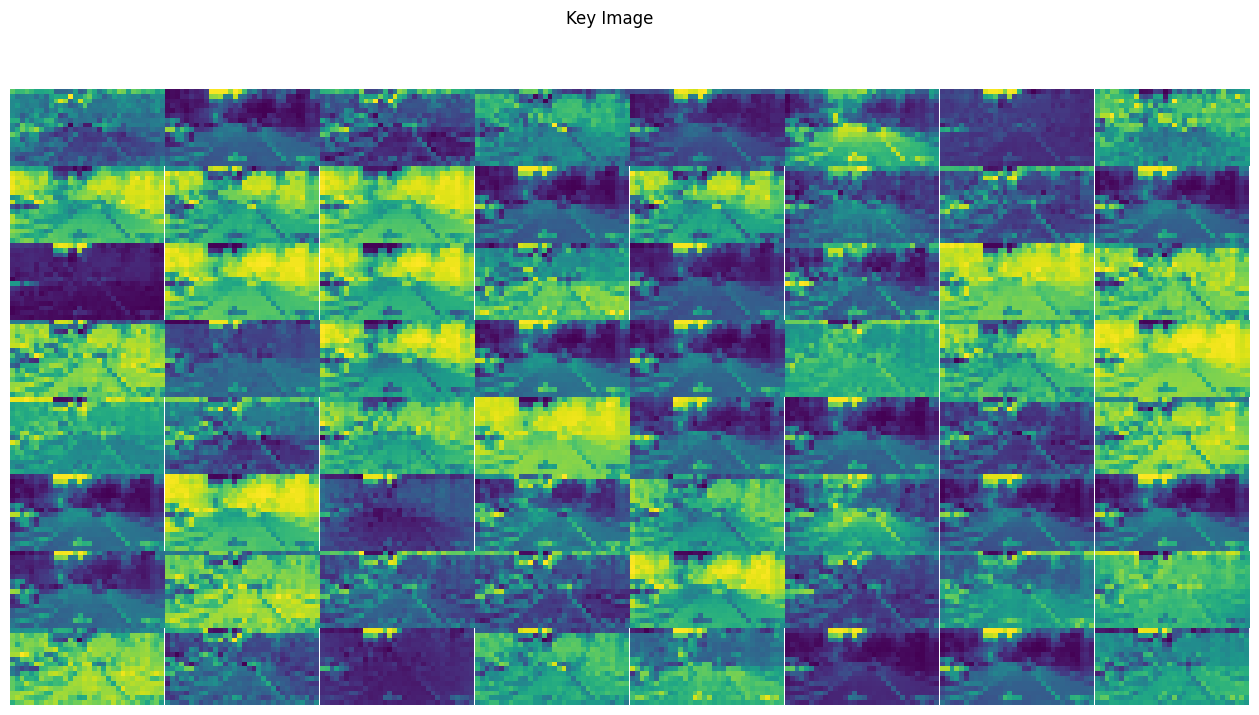

In [13]:
# key for first stage first block of transformer
key = data['key'][0][0]
key_img = rearrange(key, '(h w) c -> c h w', h=16, w=32)
print(f"key_img.shape = {key_img.shape}")

# plot each channel of Key of Transformer
plot_channels(key_img, 8, 8, (16,8), 'Key Image')

## Attention mechanism

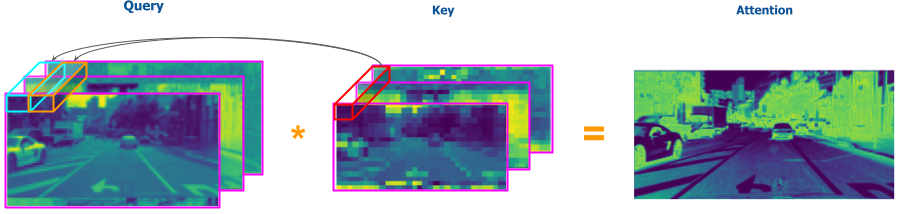

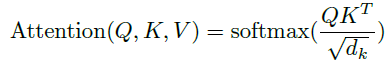

- Dot product is computed b/w each pixel combination in Query and Key matrices
- Output is scaled by key dimension and then softmax is applied
- Here, First pixel in Key contains **dark colored pixel** and we're comparing this feature with all pixels in Query Matrix
- **Pixels where query is similar to key (dark colored pixel) are given more weight in Attention output**


## Attention Visualization

attention_img.shape = (128, 256)


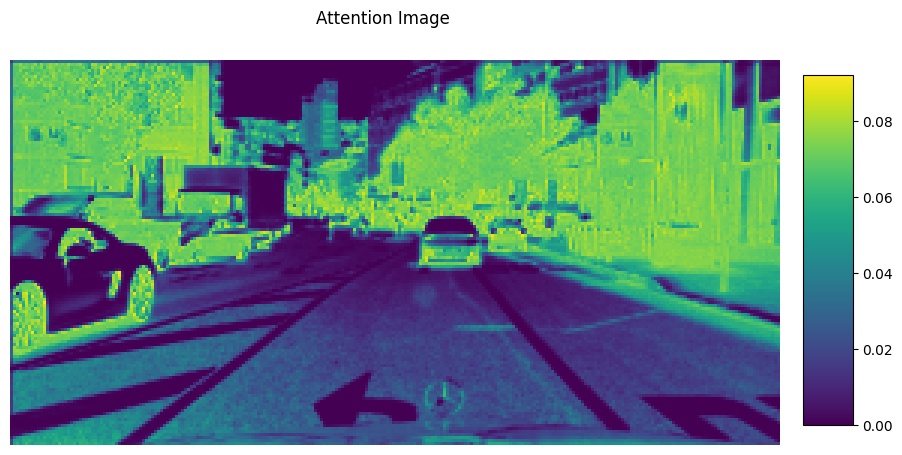

In [14]:
# Attention of 1st pixel in key w.r.t all Query pixels
attention = data['attn'][0, :, :, 0]
attention_img = attention.reshape(128,256)
print(f"attention_img.shape = {attention_img.shape}")
plot_single_channel_image(attention_img, (10,5), 'Attention Image', save_plot=True, plot_colorbar=True)

## ROI selection

In [16]:
%matplotlib ipympl
from utils import roi_select
bs = roi_select(data['rgb_img'])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.8 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'utils'

In [17]:
# convert bounding box coordinates to indices
roi_indices = bs.get_bbox_indices(scale_factor=(1.0/32))

# select attention for selected ROI
roi_attn = data['attn'][0][0]
roi_attn = rearrange(roi_attn, '(qh qw) (kh kw) -> kh kw (qh qw)', qh=128, qw=256, kh=16, kw=32)
roi_attn = roi_attn[roi_indices['min_y'] : roi_indices['max_y'], roi_indices['min_x'] : roi_indices['max_x'], :]

# rearrange dimensions to make channels first dimension
roi_attn_img = rearrange(roi_attn, 'h w (qh qw) -> (h w) qh qw ', qh=128, qw=256)
print(roi_attn_img.shape)

NameError: name 'bs' is not defined

In [18]:
plot_channels(roi_attn_img, 2, 2, (12,6), 'roi_attn Image', plot_colorbar=True)

NameError: name 'roi_attn_img' is not defined